<a href="https://colab.research.google.com/github/chloepalin/chloepalin.github.io/blob/master/workingAnimalTSNEFFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model training: Part 2

---


This notebook is part 2 of the q2. This notebook uses the animal_classifier folder (containing all the downloaded images) from the previous notebook. This folder has already been verified and omits the images that were not appropriate for the dataset. This zip folder was then uploaded to google drive, to be then imported into a new local Google Colab session to eliminate the need to search for the images each time.

In [ ]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/animal_classifier.zip

Archive:  gdrive/My Drive/animal_classifier.zip
   creating: animal_classifier/
   creating: animal_classifier/octopus/
  inflating: animal_classifier/octopus/1fe7174d-f3e1-4c77-b74a-1cd248c5e76d.jpg  
  inflating: animal_classifier/octopus/75a0da56-7989-4309-8fe0-3856983e4655.jpg  
  inflating: animal_classifier/octopus/d10769fe-ba13-4961-9831-ce55d72a8b73.jpg  
  inflating: animal_classifier/octopus/99b2d21d-c867-4908-895d-dd279f14f412.jpg  
  inflating: animal_classifier/octopus/6d5109c0-d7d7-4f9b-88fc-8d121988d917.jpg  
  inflating: animal_classifier/octopus/fded0a5d-5627-431c-ac8b-e4691d9dbb38.jpg  
  inflating: animal_classifier/octopus/439fe252-4e33-4398-94d5-ef1e54f2cfeb.jpg  
  inflating: animal_classifier/octopus/195e4313-03fa-4176-84af-61e810c140b6.png  
  inflating: animal_classifier/octopus/13363388-98fe-40dd-8449-e43c8e77432c.jpg  
  inflating: animal_classifier/octopus/1ff66c7b-7a20-4162-8c38-5ed4c7b968ec.jpg  
  inflating: animal_classifier/octopus/1f5015f2-72e4-4d33-84

Next, the test dataset was created by randomly selecting a specified number of images from each class folder in the "animal_classifier" directory. The `os.makedirs()` function creates the test folder and to ensure that the images selected are at random, `random.sample()` was used. 

It is important to form the test data set prior to any manipulation of the dataset (such as splitting into training and validation groups). Creating the test folder allows for the creation of a separate test dataset for evaluating the performance of the trained model on unseen data (Howard, J. 2023). After copying each image, `os.remove()` is used to remove the image from the original class folder within the "animal_classifier" directory. 



In [ ]:
## ChatGPT used to create the test folder and move images (OpenAI, 2022)
from pathlib import Path
import random
import shutil
import os

# Define the test folder path
test_folder = Path('test')  # Replace with your desired path

# Create the test folder
os.makedirs(test_folder, exist_ok=True)

# Specify the number of random images to select from each class
num_images_per_class = 40

# Iterate over the class folders in the animal_classifier folder
for class_folder in Path('animal_classifier').iterdir():
    if class_folder.is_dir():
        images = list(class_folder.glob('*.jpg'))
        # Select random images from the class folder
        selected_images = random.sample(images, min(num_images_per_class, len(images)))

        # Copy the selected images to the test folder while preserving the directory structure
        for image in selected_images:
            destination_folder = test_folder / class_folder.name
            os.makedirs(destination_folder, exist_ok=True)
            shutil.copy(image, destination_folder)

            # Remove the image from the original animal_classifier folder
            os.remove(image)

Next, a DataBlock is created for the model to then learn and be fine tuned. This process was explained and followed in the previous notebook.

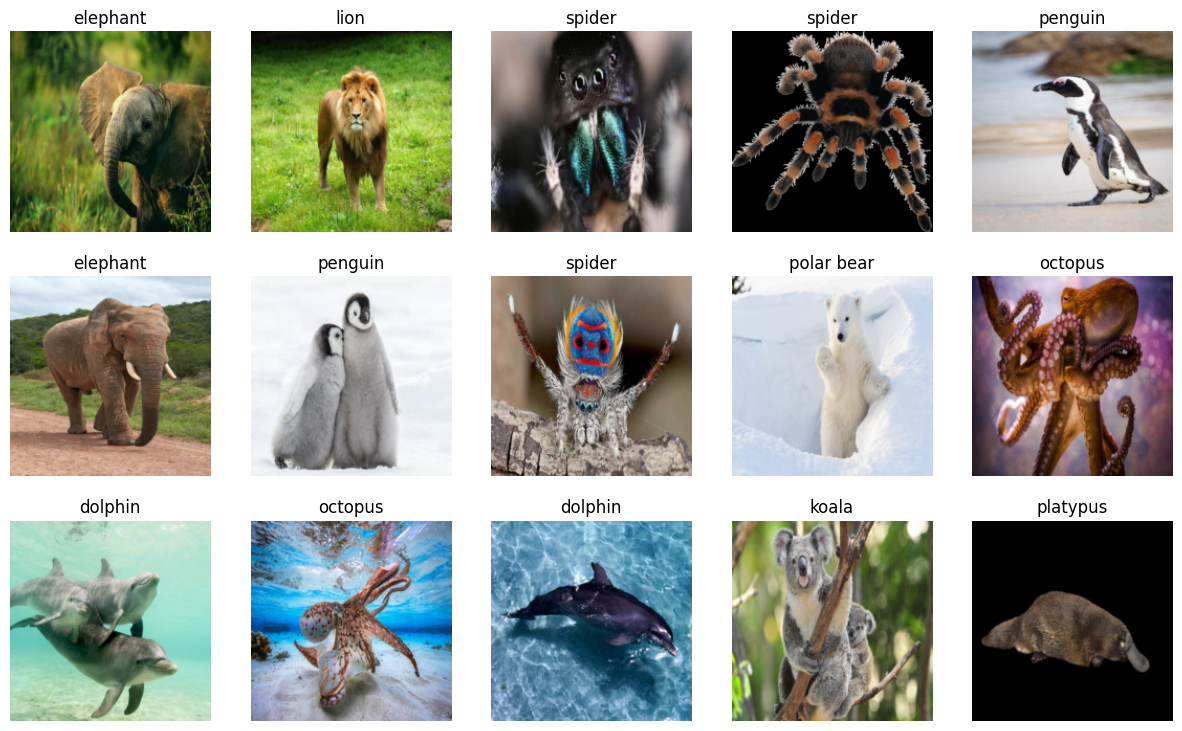

In [ ]:
from fastai.vision.all import *
path = Path('animal_classifier')

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=15)


In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 79.5MB/s]


In [ ]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.891892,0.574912,0.174419,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.528253,0.155873,0.058140,00:03
1,0.328620,0.043056,0.011628,00:02
2,0.224524,0.028043,0.011628,00:02
3,0.163523,0.026633,0.011628,00:02


Next, the `test_dl()` method is called on the dls (DataLoaders) object associated with the learn object. This creates a test DataLoader (dl) by loading the test dataset (files) along with their corresponding labels. Using the test DataLoader ensures that the test dataset is prepared for evaluation. 

## Assessing model performance


---



The `ClassificationInterpretation` class is instantiated with the trained learn object and the test DataLoader. This class provides useful methods for interpreting and analysing the results of the classification model. In order to evaluate the effectiveness of the chosen loss function, a confusion matrix was performed to provide a comprehensive summary of the model's classification performance. The confusion matrix reveals the number of correct and incorrect predictions for each animal class, enabling a detailed assessment of the model's accuracy. Through interpreting the confusion matrix, identification of patterns of misclassification and biases within the model's predictions can be established.




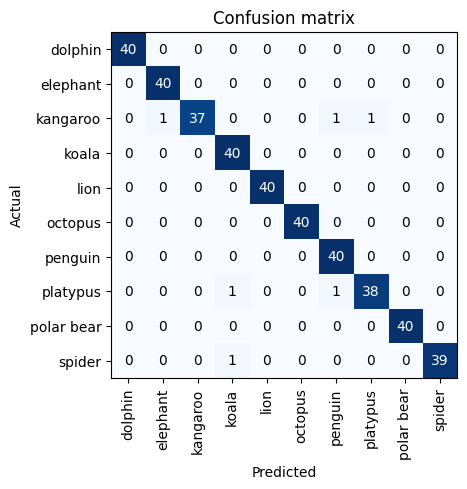

In [ ]:
# Test dataset
files = get_files('test')

dl = learn.dls.test_dl(files, with_labels=True)

interp = ClassificationInterpretation.from_learner(learn, dl=dl)
interp.plot_confusion_matrix()

The rows in the confusion matrix correspond to the different animal classes present in our dataset, while the columns represent the images from the test dataset that were classified by the model. The diagonal cells of the confusion matrix represent the instances where the model correctly predicted the animal class. These are the true positive cases, indicating that the model accurately classified the image according to its actual label. The off-diagonal cells in the matrix indicate the instances where the model made incorrect predictions. These are the false positive, representing confusion between different animal classes.

The small number of false positive results suggests that the classifier has achieved a high level of accuracy, with a strong ability to correctly classify the animal images in the test dataset. The accuracy of the model is reported as 98.5%.


In [ ]:
cm = interp.confusion_matrix()
accuracy = (cm.diagonal().sum() / cm.sum()).item()
print(f"Accuracy: {accuracy}")

Accuracy: 0.985


Analysing the errors made by the model is essential for understanding the origin of them; whether they arise from issues within the dataset itself or limitations in the model's ability to handle certain variations in the images. Sorting the images by their loss therefore enables a focused investigation into the instances where the model encountered the greatest challenges.

By examining the images with the highest loss, valuable insights can be gained regarding the potential presence of dataset problems, such as incorrect labels or images that do not accurately depict the selected animals. Conversely, if images with high loss exhibit challenging lighting conditions or unusual angles, it suggests that the model may struggle with such variations (Howard, J. 2023).

 The images with the highest loss in the dataset are presented in the following plot. The probability parameter is the confidence level, from 0 to 1, that the model has assigned to its prediction.

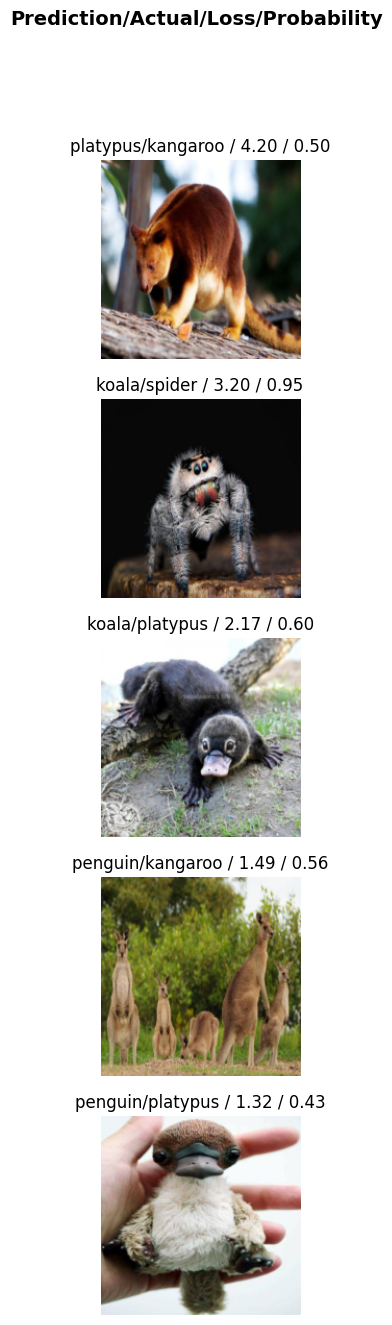

In [ ]:
interp = ClassificationInterpretation.from_learner(learn, dl=dl)
interp.plot_top_losses(5, nrows=5)

To further evaluate the effectiveness of the chosen loss function, t-SNE (t-Distributed Stochastic Neighbor Embedding) is used. t-SNE is a powerful dimensionality reduction technique that maps high-dimensional data onto a lower-dimensional space. It also preseves found relationships between data points (Stefanus, 2020). The plot was formed with assistance from ChatGPT to ensure correct class labelling of the animal predictions made.


<ipython-input-54-e58d326ddb00>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colour_map = plt.cm.get_cmap('tab10', len(np.unique(labels)))


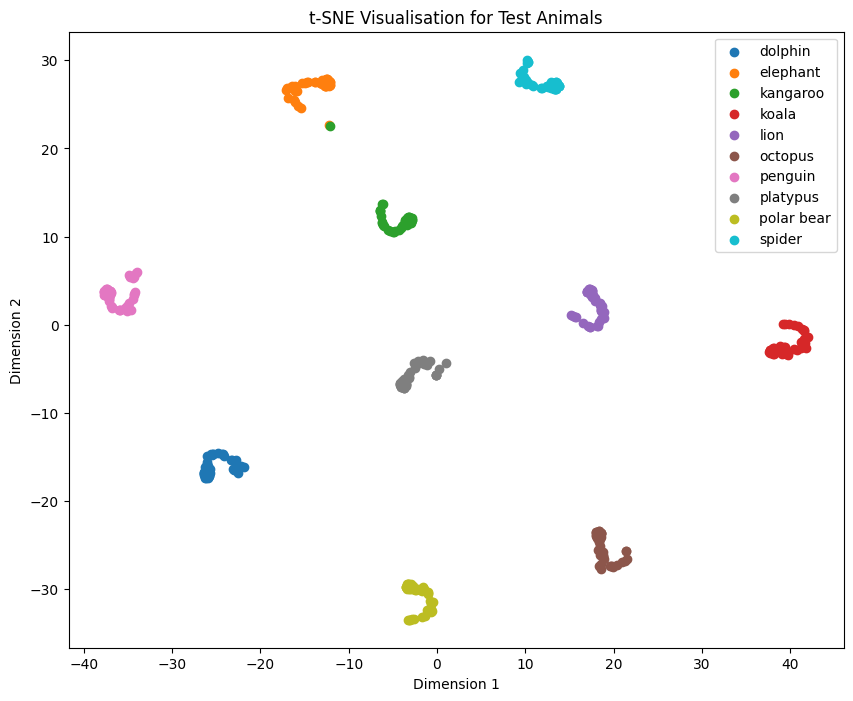

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Get predictions using get_preds()
preds, _ = learn.get_preds(dl=dl)

# Apply t-SNE on the predictions
tsne = TSNE(perplexity=20)
embeddings = tsne.fit_transform(preds.numpy())

# Get the predicted labels
labels = np.argmax(preds.numpy(), axis=1)

# Get the class names
class_names = dls.vocab

## t-SNE plot formed using ChatGPT (OpenAI, 2022)
# Create a colour map for the clusters
colour_map = plt.cm.get_cmap('tab10', len(np.unique(labels)))

# Plot the t-SNE embeddings with colour-coded clusters
plt.figure(figsize=(10, 8))
for i, name in enumerate(class_names):
    plt.scatter(embeddings[labels == i, 0], embeddings[labels == i, 1], c=[colour_map(i)], label=name)
plt.title("t-SNE Visualisation for Test Animals")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

In this particular case, the t-SNE plot successfully demonstrates the appropriate clustering of the ten animals, highlighting their distinct characteristics. The animals are well-separated and form distinct clusters. Each cluster represents a specific animal class, indicating how the model has effectively learned to differentiate between different species based on their visual features. This outcome is highly desirable and indicates that the model has successfully captured the unique visual attributes that define each animal class. Additionally, the clustering pattern indicates that the model has captured important visual cues such as body shape, color patterns, and other distinguishing features specific to each animal class.

Moreover, t-SNE plots can provide valuable insights into the relationships between different animal classes. However, in this case, the clusters appear well-defined, suggesting that the model has effectively learned to differentiate even closely related animal species, such as polar bears and penguin snow desert environments . 

As such, the successful clustering of the ten animals in the t-SNE plot hence reflects the robustness of the model's learned representations. It demonstrates the model's ability to capture and utilise visual cues effectively, enabling accurate classification (Stefanus, 2020). The presence of distinct clusters signifies that the model has achieved a high level of classification between different animal classes. For practical applications, the t-SNE plot is useful to provide information for wildlife conservation, species identification, and ecological research.





## Model Production


---


To make the animal image classification more interactive/visual, a GUI was implemented.The model was exported to ensure that the model's architecture, parameters, and the definition of the DataLoaders used during training are all saved. This is particularly crucial as it eliminates the need to redefine data transformations when deploying the model in production. 

Firstly, a file upload widget was implemented to allow users to select an image from the test file for classification. This widget facilitates the seamless retrieval of the chosen image for further processing. Once the image is uploaded, the next step extracts and storing the image data in a designated variable. To respond to user interaction, a click event handler function is triggered when the user presses a specific button, facilitating the prediction of the corresponding animal class based on the uploaded image. 

As such, the GUI can allow users of the model to upload images, execute image prcoessing tasks and then acquire accurate predicitions based on the trained model. The GUI code is inspired by lesson 2 of the Fastai course (Howard, J. 2020).







In [ ]:
learn.export()


In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
learn_inf = load_learner(path/'export.pkl')


In [ ]:
!pip install voila
!pip install ipywidgets
!jupyter serverextension enable --sys-prefix voila

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Uninstalling requests-2.27.1:
      Successfully uninstalled requests-2.27.1
  Attempting uninstall: jsonschema
    Found existing installation: jsonschema 4.3.3
    Uninstalling jsonschema-4.3.3:
      Successfully uninstalled jsonschema-4.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency confl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.1 MB/s eta 0:00:00
Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
      voila 0.4.0 OK


In [ ]:
!zip -r /content/testAnimals.zip /content/test

  adding: content/test/ (stored 0%)
  adding: content/test/kangaroo/ (stored 0%)
  adding: content/test/kangaroo/b59bed69-62db-40f2-8ac8-98e1be14e8d9.jpg (deflated 1%)
  adding: content/test/kangaroo/5c8da085-1891-4619-825d-364ea4a83e89.jpg (deflated 0%)
  adding: content/test/kangaroo/f5b0b0f4-4c8c-47eb-9471-88e60e437e83.jpg (deflated 1%)
  adding: content/test/kangaroo/2444a899-d625-4f2c-a33a-05c69c410308.jpg (deflated 1%)
  adding: content/test/kangaroo/e63b8f7b-e20c-4cf1-809d-089898c97256.jpg (deflated 1%)
  adding: content/test/kangaroo/2b86efbd-8935-4aef-9f34-896463823ce3.jpg (deflated 0%)
  adding: content/test/kangaroo/ce7593d9-ec51-407a-ab5e-072e3cd2d35a.jpg (deflated 1%)
  adding: content/test/kangaroo/f386c30e-810f-4ce2-9097-2a8e6a99beba.jpg (deflated 0%)
  adding: content/test/kangaroo/9733d3ad-7f15-450d-9ba6-7a36fea1df80.jpg (deflated 0%)
  adding: content/test/kangaroo/b3087d54-42e3-413f-bcd9-d7d7c1190329.jpg (deflated 0%)
  adding: content/test/kangaroo/c1e1b112-2b30-4c6

In [ ]:
from ipywidgets import widgets, Output, VBox
from IPython.display import display, Image
from fastai.vision import *

btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
uploaded_image = PILImage.create(btn_upload.data[-1])
    
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(uploaded_image.to_thumb(128,128))
out_pl


Output()

In [ ]:
btn_upload = widgets.FileUpload()

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
pred,pred_idx,probs = learn_inf.predict(uploaded_image)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

VBox([widgets.Label('Select your animal!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### References
Howard, J., & Gugger, S. (2020). Deep Learning for Coders with Fastai and Pytorch: AI Applications Without a PhD. O'Reilly Media, Incorporated.

fastai. (n.d.). data.core. Retrieved from https://docs.fast.ai/data.core.html

fastai. (n.d.). vision.models.xresnet. Retrieved from https://docs.fast.ai/vision.models.xresnet.html

OpenAI. (2022). ChatGPT (May 5 version). [Large language model]. Retrieved from https://chat.openai.com/

Stefanus, R. (2020, October 30). The underlying idea of t-SNE. Medium. Retrieved from https://medium.com/data-folks-indonesia/the-underlying-idea-of-t-sne-6ce4cff4f7